# Hyperspectral image ground classification
## Using Machine Learning

In [6]:
import utils as u
import preprocessing as pp
import train as tt
import visualization as viz

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

from keras.utils import np_utils

import spectral
from spectral import spy_colors

#tests
from sklearn.cluster import KMeans

### Globals and hyperparameters

In [7]:
numPCAcomponents = 50
PATCH_SIZE = 5
C1 = 3*numPCAcomponents

batch_size = 128
epochs = 10

classes_authorized = [2,3,5,6,10,0,11,12,14,15]

target_names = ['Maïs- Pas de Technique de Conservation des sols',
                    'Maïs- Minimum Tillage',
                    'Herbe-Pâturage',
                    'Herbe-Arbre',
                    'Soja-Pas de Technique de Conservation des sols', 'Soja-Minimum Tillage','Soja', 'Bois',
                    'Bâtiment-Herbe-Arbre-drives',]

label_dictionary = {
    0: 'Rien',
    1: 'Maïs- Pas de Technique de Conservation des sols', 
    2: 'Maïs- Minimum Tillage',
    3: 'Herbe-Pâturage', 
    4: 'Herbe-Arbre', 
    5: 'Soja-Pas de Technique de Conservation des sols', 
    6: 'Soja-Minimum Tillage',
    7: 'Soja', 
    8: 'Bois', 
    9: 'Bâtiment-Herbe-Arbre-drives',
}

### Preprocessing

In [8]:
X, train_data, test_data = pp.loadData()

In [9]:
train_data = pp.deleteUselessClasses(train_data, classes_authorized)
test_data = pp.deleteUselessClasses(test_data, classes_authorized)

def pretty_print_count(train_data, test_data):
    unique_train = np.unique(train_data, return_counts=True)
    unique_test = np.unique(test_data, return_counts=True)
    for i in range(0, unique_train[0].shape[0]):
        print(unique_train[0][i], "=>", unique_train[1][i], "/", unique_test[1][i])
    print()
        
print("Before Shuffle: ")
pretty_print_count(train_data, test_data)
train_data, test_data = pp.shuffleTrainTest(train_data, test_data)
print("After Shuffle: ")
pretty_print_count(train_data, test_data)

Before Shuffle: 
0 => 15155 / 17753
1 => 648 / 780
2 => 751 / 79
3 => 465 / 18
4 => 492 / 238
5 => 231 / 741
6 => 1646 / 809
7 => 403 / 190
8 => 1145 / 120
9 => 89 / 297

After Shuffle: 
0 => 16441 / 16467
1 => 700 / 728
2 => 435 / 395
3 => 249 / 234
4 => 382 / 348
5 => 481 / 491
6 => 1205 / 1250
7 => 317 / 276
8 => 635 / 630
9 => 180 / 206



In [10]:
X, pca = pp.dimensionalityReduction(X, numComponents=numPCAcomponents, standardize=False)

In [11]:
X_train, X_test, y_train, y_test = pp.patch_1dim_split(X, train_data, test_data, PATCH_SIZE)

Progress:  |████████████████████████████████████████| 100.0%  Complete

Creating train/test arrays and removing zero labels...
Progress:  |████████████████████████████████████████| 100.0%  Complete
Done.


In [12]:
X_train, y_train = pp.BoostDataset(X_train, y_train, n_samples=100)

Boosting Dataset...
Progress:  |████████████████████████████████████████| 100.0%  Complete


In [13]:
y_train = np_utils.to_categorical(y_train, num_classes=9)
y_test = np_utils.to_categorical(y_test, num_classes=9)

### END PREPROCESSING ###

In [14]:
## Prints preprocessing

t,v = np.unique(train_data, return_counts=True)
print(t, v)
t,v = np.unique(test_data, return_counts=True)
print(t, v)


[0 1 2 3 4 5 6 7 8 9] [16441   700   435   249   382   481  1205   317   635   180]
[0 1 2 3 4 5 6 7 8 9] [16467   728   395   234   348   491  1250   276   630   206]


### Train our model

In [15]:
input_shape= X_train[0].shape
print(input_shape)

(5, 5, 50)


In [ ]:
X2 = np.reshape(X, (X.shape[0]* X.shape[1], X.shape[2]))
print(X2.shape)
kmeans = KMeans(n_clusters=9, random_state=0).fit(X2)
kmeans.labels_
k = kmeans.predict(y_train)
print(k.shape)

In [17]:
sequential_cnn_model = tt.sequential_cnn_model(input_shape, C1, numPCAcomponents)

# On a 9 classes en réalité, donc une accuracy > 100/9 ~=11.11 est supérieure au hasard. 
sequential_cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

model = sequential_cnn_model

Epoch 1/10
4684/4684 [==============================] - 3s 669us/step - loss: 1.8379 - acc: 0.3747
Epoch 2/10
4684/4684 [==============================] - 2s 469us/step - loss: 1.1207 - acc: 0.6112
Epoch 3/10
4684/4684 [==============================] - 2s 459us/step - loss: 0.7497 - acc: 0.7444
Epoch 4/10
4684/4684 [==============================] - 2s 466us/step - loss: 0.5204 - acc: 0.8273
Epoch 5/10
4684/4684 [==============================] - 2s 477us/step - loss: 0.3728 - acc: 0.8817
Epoch 6/10
4684/4684 [==============================] - 2s 474us/step - loss: 0.2712 - acc: 0.9170
Epoch 7/10
4684/4684 [==============================] - 2s 495us/step - loss: 0.1923 - acc: 0.9462
Epoch 8/10
4684/4684 [==============================] - 2s 458us/step - loss: 0.1437 - acc: 0.9614
Epoch 9/10
4684/4684 [==============================] - 2s 467us/step - loss: 0.1067 - acc: 0.9718
Epoch 10/10
4684/4684 [==============================] - 2s 458us/step - loss: 0.0782 - acc: 0.9831


### Visualization

In [18]:
y_train.shape

(4684, 9)

In [20]:
classification, confusion, Test_loss, Test_accuracy = viz.reports(model, X_test,y_test, target_names)

4558/4558 [==============================] - 1s 170us/step


In [21]:
print(classification)

                                                 precision    recall  f1-score   support

Maïs- Pas de Technique de Conservation des sols       0.94      0.93      0.94       728
                          Maïs- Minimum Tillage       0.96      0.96      0.96       395
                                 Herbe-Pâturage       1.00      0.96      0.98       234
                                    Herbe-Arbre       0.97      1.00      0.98       348
 Soja-Pas de Technique de Conservation des sols       0.94      0.93      0.93       491
                           Soja-Minimum Tillage       0.95      0.96      0.95      1250
                                           Soja       0.90      0.93      0.92       276
                                           Bois       0.96      1.00      0.98       630
                    Bâtiment-Herbe-Arbre-drives       0.98      0.85      0.91       206

                                    avg / total       0.95      0.95      0.95      4558



Normalized confusion matrix


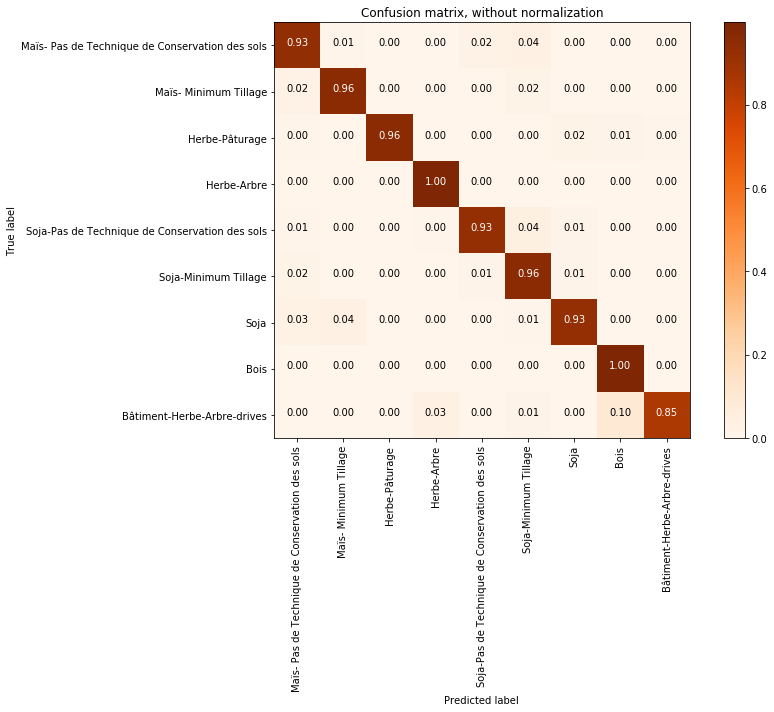

In [22]:
plt.figure(figsize=(13, 10))
viz.plot_confusion_matrix(confusion, classes=target_names,
                      title='Confusion matrix, without normalization')

In [23]:
X_garbage, train_data, test_data = pp.loadData()
#X = dimensionalityReduction(X, )
y = np.add(train_data, test_data)
y = pp.deleteUselessClasses(y, classes_authorized)

In [24]:
outputs = viz.createPredictedImage(X, y, model, 5, y.shape[0], 145)

Progress:  |████████████████████████████████████████| 100.0%  Complete


[0 1 2 3 4 5 6 7 8 9]


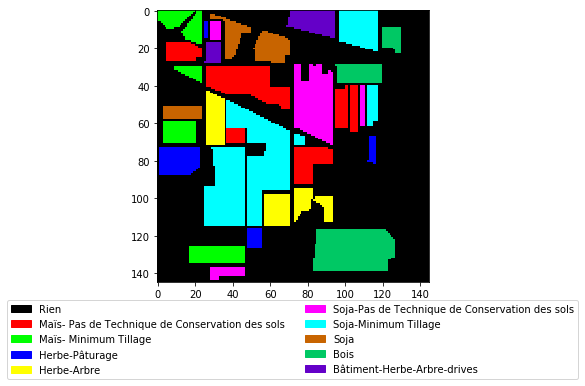

In [25]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))
print(np.unique(y))

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=label_dictionary[x]) for x in np.unique(y) ]
plt.legend(handles=labelPatches, ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));